# CM50268 :: Coursework Part 2 :: Monte Carlo Sampling in Bayesian Regression

**Total Marks 15 (15% of overall unit grade).** 

*Submission deadline: 8pm, March 24, 2023. Please submit this file and the Part 1 file together in Moodle*

## Overview of Part 2 tasks

Coursework Part 2 focuses on implementing Monte Carlo sampling for computing useful expectations in the Bayesian linear regression model, using methodology covered in Lectures 6 and 8. Primarily it involves the implementation of *importance sampling* and the *Metropolis algorithm* (MCMC). It will build on some of the computations undertaken in Part 1.

The data studied will be synthetic (generated from randomly weighted basis functions) with additive Gaussian noise. The data is to be modelled with the usual linear (in-the-parameters) model, with Gaussian "RBF" basis functions of unspecified width/radius/length-scale $r$. The primary aims of the lab are to estimate $\alpha$, $r$ and, later, the noise $\sigma^2$. Recap: $\alpha=\lambda/\sigma^2$, where $\lambda$ is the regularisation parameter in penalised OLS. 

There are three principal tasks (detailed below), with varying marks. In summary here:

[Task 4](#task4): Compute and visualise the form of the posterior over hyperparameter $\alpha$ and basis function width $r$ (4 marks)

[Task 5](#task5): Implement the importance sampling procedure to estimate the posterior mean width parameter $r$ for the Gaussian "RBF" basis functions in the linear model (given known noise $\sigma^2$). This will involve experimenting with different proposal distributions, and comparing convergence (5 marks + 1 bonus marks)

[Task 6](#task6): Implement the Metropolis MCMC algorithm to estimate the basis length-scale $r$, again for different proposals. Extend this to estimation of $\sigma^2$, and ultimately to model weights $\mathbf{w}$, thereby computing a mean predictor (6 marks + 1 bonus mark)


## Setup

To get started, the code cell below imports the requisite standard modules, plus a setup module `CM50268_CWP2_setup` specific to this lab. It is imported as `CWP2`. This module contains:
- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian RBF basis matrices $\Phi$ of varying order,
- specimen functions `compute_posterior` and `compute_log_marginal` as implemented for Coursework Part 1.
- a basic function `plot_regression` for graphing predictors (again, you may choose to use your own).


In [1]:
##
## Setup
##
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats, spatial
# Lab-specific support module
import CM50268_CWP2_setup as CWP2

We also set some "constants" here: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.2$ for the entire exercise. Mainly we will assume it is known for modelling purposes, although in one later exercise we will estimate it.

The centres (locations) of the basis functions are fixed here (the length scale, or width, $r$ of those basis functions will be varied during the exercise).


In [2]:
##
## Setup
##
## Define some fixed values
##

# Parameters that determine the generated data
#
sig_gen = 0.2  # Standard deviation
s2_gen = sig_gen**2  # Variance
r_gen = 1  # Basis function width used to generate the data
x_max = 10  # x-limit of the data
#
N_train = 30
N_test = 250

# Parameters that determine the basis set used for modelling
# - note that the length scale "r" will be varied
#
M = 16 # Number of functions, spaced equally
centres = np.linspace(0, x_max, M)


### Generate Data
We synthesise two data sets:
- a training set of size $N=30$ with added noise of std. dev. $\sigma=0.2$
- a test set of size $N=250$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0,10]$.

### Generate Basis
For our linear (in-the-parameters) model, we utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. Each basis function has its own center $c_m$; these are equally spaced and will remain fixed. The length scale, or width, $r$ is common across basis functions, and will be varied.

### Example Model Fit
For an arbitrarily selected set of sub-optimal values of $\alpha$, $\sigma^2$ and $r$, the posterior mean predictor is computed and graphed below (using `plot_regresssion`) for illustrative purposes. In particular, it also demonstrates how `RBFGenerator` is used (you will need this).


Measured noise std. dev. = 0.194


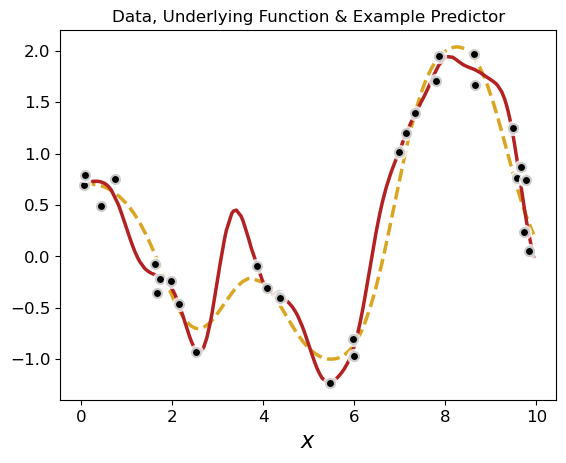

In [3]:
# Generate training data
seed = 4
Data = CWP2.DataGenerator(m=9, r=r_gen, noise=sig_gen, rand_offset=seed)
x_train, y_train = Data.get_data('TRAIN', N_train)
x_test, y_test = Data.get_data('TEST', N_test)

# Demonstrate use of basis
r = r_gen * 0.5  # Example model uses basis functions that are too narrow
RBF = CWP2.RBFGenerator(centres, r) # centres were fixed earlier
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)

# Find posterior mean for fixed guesses for alpha and s2
alph = 1e-12
s2 = 0.2**2
mu, _ = CWP2.compute_posterior(PHI_train, y_train, alph, s2)
fy_test = PHI_test @ mu

# Show the training data and generating function, plus our mean fit
CWP2.plot_regression(x_train, y_train, x_test, y_test, fy_test)
plt.title("Data, Underlying Function & Example Predictor")
pass 

# Overall Objective

Although there are some varied exercises in this coursework, most centre around the estimation of a "good" value for the basis function width parameter $r$ given our training data.

This is not a "strictly Bayesian" objective. Ideally, of course, we would make predictions by *integrating* over $r$, but we might imagine that when our model is deployed (as can often be the case in real world applications), there won't be the opportunity to undertake any extended Bayesian computations (*e.g.* running sampling algorithms to calculate predictive distributions in real time). So we are taking a pragmatic viewpoint, and considering how we might find a single good setting for our basis function length-scale.

Our model takes the standard form of $y = \sum_m^M w_m \phi_m(x)$, a linearly-weighted sum of basis functions as defined above: $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. These basis functions have fixed locations $c_m$; but we are free to adjust the common length-scale $r$.

So we will employ our Bayesian techniques now, in the "model development" phase, to determine a good value of $r$ that might be used in any ultimate model. Following good Bayesian practice, we will estimate the optimal values by integrating out (averaging over) the other unknowns (the "nuisance variables"). Because most of the integrations are analytically intractable, we will need to utilise sampling techniques, and this aspect is the focus of this coursework.


## Task 4: Computing & Visualising the Hyperparameter Posterior <a name="task4"></a>
(4 marks)

Assume for now that the data noise variance $\sigma^2=0.2^2$ is a known quantity, and for clarity we will omit it from the probability distribution notation below. We will look at estimating $\sigma^2$ later in the lab (in Task 3, using the Metropolis MCMC algorithm).



### Task 4a

*Compute the hyperparameter posterior (1 mark)*

The first thing to do is to write a function to compute $p(\alpha, r | y)$, where $y$ is the training data (vector) `y_train`. Using Bayes' rule:

$$p(\alpha, r | y) = \frac{p(y|\alpha,r)\, p(\alpha)\, p(r)}{p(y)}$$

We cannot compute this analytically, as the denominator $p(y)$ is intractable. But to visualise its shape, we can calculate the numerator, which we typically refer to as $P^\ast(\alpha, r)$. The first term in the numerator $p(y|\alpha,r)$ is the marginal likelihood calculated in Coursework Part 1 (though note the dependence on $r$, which will change $\Phi$). The second two terms are priors for $\alpha$ and $r$. These are both scale parameters, so it is appropriate to use an uninformative, uniform prior, *on a log scale*. As such, *those terms can be treated as constant and ignored*, provided we work with $\log\alpha$ and $\log r$ in our sampling. So, $p(\alpha, r | y) \propto p(y|\alpha,r)$, and we only need compute the latter.

It is suggested that the log p.d.f., $\log p(\alpha, r | y)$, is computed by a function of the form: `log_prob_alph_r_given_y(alph, r, s2, x, y, centres)`. If the probability itself is required, this can be obtained by exponentiating.

This function will need to create a new `RBFGenerator` object and recompute the basis matrix (as this changes with $r$), then call `compute_log_marginal()` as appropriate.


In [4]:
#### **** YOUR CODE HERE **** ####

#### Task 4a

#### Your implementation 

def log_prob_alph_r_given_y(alph, r, s2, x, y, centres):
    #### **** YOUR CODE HERE **** ####
    """ This function returns the log marginal probabilities
        for given values alpha, r and s2 
        
        Arguments
        ---------
        alph: alpha
        r
        s2: sigma-squared
        x: x_train/test
        y: y_test/train
        centres
        
        Returns
        -------
        marginal: compute_log_marginal
        """
    
    RBF = CWP2.RBFGenerator(centres, r)
    PHI = RBF.evaluate(x)
    log_prob_y = CWP2.compute_log_marginal(PHI, y, alph, s2)
    return log_prob_y

### Task 4b
*Visualise the hyperparameter posterior and find its maximum (3 marks)*

Next, you should visualise $p(\alpha, r | y)$, and its logarithm, as implemented in Task 4a.

The following approach is suggested:

- Compute this function over a regular *logarithmic* grid of $\alpha$ and $r$ values
- For consistency and interpretability, use decimal logs (so `x = np.log10(r)` and `r = 10**x`)
- (Decimal logs apply only to the parameter values: **you should still use natural, exponential, logs for log probabilities!**)
- The fixed ranges are:
    - $\log_{10}\alpha \in [-9,+6]$, 100 sampling steps is enough.
    - $\log_{10} r \in [-2,+2]$, 100 sampling steps is enough.
   
- Visualise the resultant matrix of $\log p(y|\alpha,r)$ with `plt.contour()` or `plt.contourf()` (**important**: please use logarithmic values for $\alpha$ and $r$)
- Arrange it so that $\log\alpha$ is on the horizontal axis, $\log r$ on the vertical (just for consistency)
- You should find that plotting $\log p(y|\alpha,r)$(`log_prob_y`)is more informative than plotting $p(y|\alpha,r)$(`prob_y`) - **you should show both**

If all goes to plan, your $\log p(y|\alpha,r)$ plot, visualised on log-10 scales for $\alpha$ and $r$, should have a maximum (plateau) not very far from the origin (0,0). You should find that plotting $p(y|\alpha,r)$ is rather uninteresting.

Once you have your visualisation, find the maximum, and **print out the corresponding most probable $\alpha$ and $r$ values and its log probabilities**. 

In [5]:
import numpy as np

In [6]:
#### **** YOUR CODE HERE **** ####

#### Tasks 4b

#### Calculate p(alpha,r|y) and log p(alpha,r|y) for visualisation. 

x_alpha = np.linspace(-9, 6, 16)                     # Equally spaced log alpha values
x_r = np.linspace(-2, 2, 5)                          # Equally spaced log r values

alpha = 10**x_alpha                                  # alpha
r = 10**x_r                                          # r
s2 = 0.2**2                                          # sigma-squared

log_prob_y_mat = []
prob_y_mat = []

for i in alpha:
    in_mat = []
    in_mat2 = []
    for j in r:
        log_prob_y = log_prob_alph_r_given_y(i, j, s2, x_train, y_train, centres) # Calculates logML values for each log alpha and log r values
        prob_y = np.power(10,log_prob_y)                                              # Marginal Probability
        in_mat.append(log_prob_y)
        in_mat2.append(prob_y)
        
        
    log_prob_y_mat.append(in_mat)
    prob_y_mat.append(in_mat2)
    
print('log_prob_y:')
for i in range(0,len(alpha)):
    print(log_prob_y_mat[i])
    
print('prob_y:')
for i in range(0,len(alpha)):
    print(prob_y_mat[i])
    


# Check whether your variables are defined as required  ..
try:
    log_prob_y
    prob_y
except Exception as err:
    print('Error during drawing contour lines :', err)

log_prob_y:
[-299.84592548504577, -198.08285509961922, -166.31560732958204, -83.84541116825537, -211.33940993282147]
[-295.24077501972243, -182.0208018894847, -147.89492970199439, -90.18174645586184, -218.24512658699533]
[-290.6358020124624, -171.4121538410191, -129.47428011985303, -88.6419894179995, -235.80628604573317]
[-286.03260082640685, -163.4266892902532, -111.05391093671241, -93.32491679261948, -240.11086108883867]
[-281.4468464198277, -151.05544977858304, -92.63633991222476, -112.48772963819323, -238.63453571462787]
[-277.0122661078663, -137.43174557438266, -74.24618468436249, -119.51431815052894, -236.51507730509366]
[-273.1926882619554, -123.88006748591113, -56.0863956338471, -133.21100951354433, -235.1973812544857]
[-269.80081804130475, -112.45896398023021, -38.95318746652219, -169.31247203245766, -241.0577217157534]
[-266.74678799179253, -117.1814809892073, -23.90465214877876, -184.02250734344577, -266.7053446311218]
[-266.94433693160994, -162.61333237189385, -13.208126080

C:\Users\Victor Adescope\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 120572 (\N{MATHEMATICAL ITALIC SMALL ALPHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


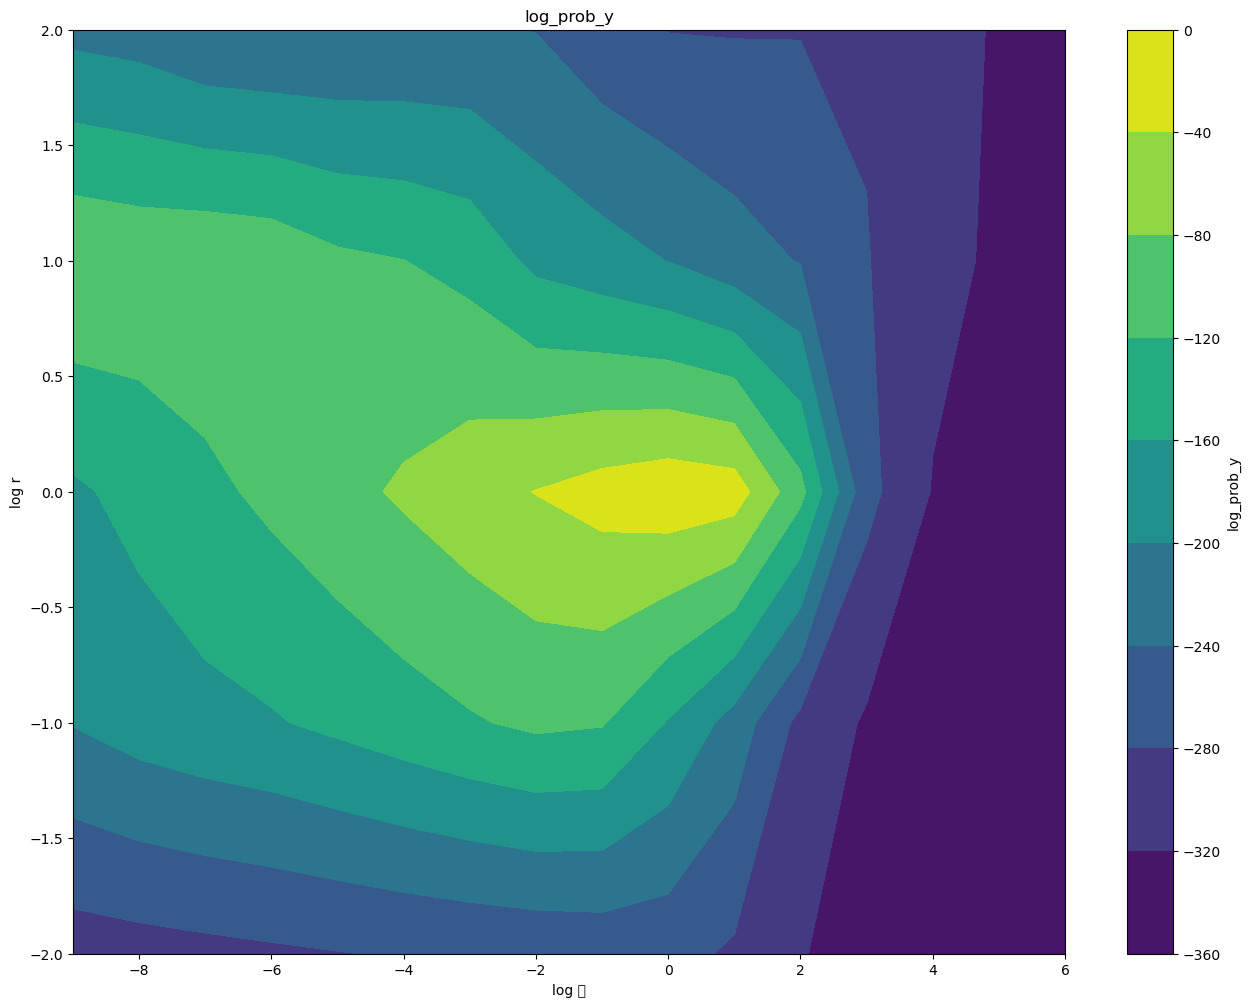

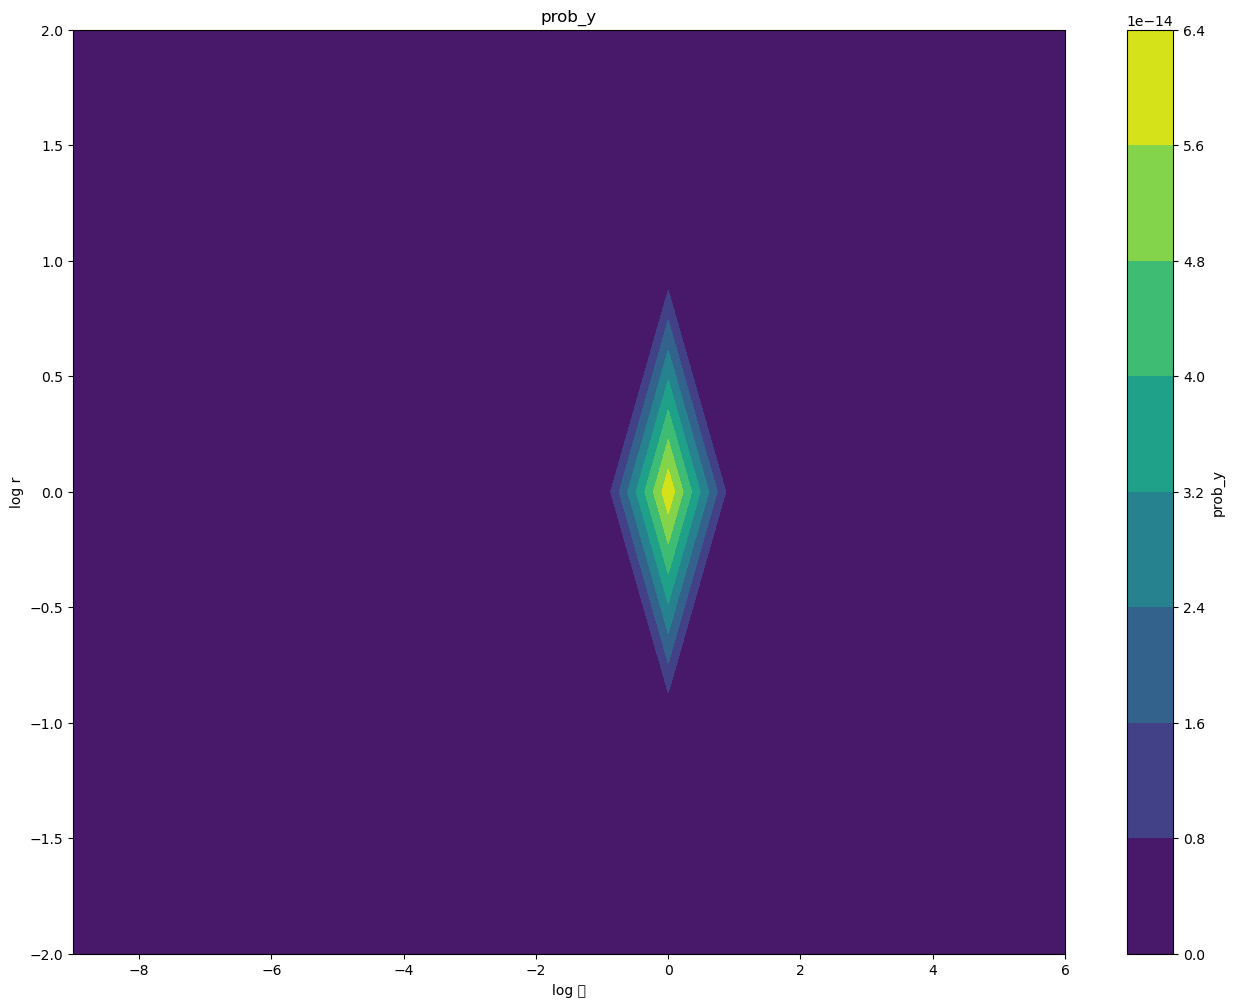

In [7]:

#### Tasks 4b

#### Output should be the visualisation of p(alpha,r|y) and log p(alpha,r|y) in two separate figures. 

#
#### **** YOUR PLOTTING CODE HERE **** ####
#

plt.figure(figsize=(16,12))

plt.contourf(x_alpha, x_r, np.transpose(log_prob_y_mat))
plt.xlabel('log 𝛼')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('log_prob_y')
plt.title('log_prob_y')
plt.show()

plt.figure(figsize=(16,12))

plt.contourf(x_alpha, x_r, np.transpose(prob_y_mat))
plt.xlabel('log 𝛼')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('prob_y')
plt.title('prob_y')
plt.show()

In [8]:
#### Add some code to print out of the most probable alpha and r values and its log probabilities

#### **** YOUR CODE HERE **** ####

import math

index = np.argmax(log_prob_y_mat)
r_ind = index%5
alpha_ind = math.floor(index/5)
print('Max log_prob_y at:')
print('x_r: ', x_r[r_ind])
print('x_alpha: ',x_alpha[alpha_ind])

Max log_prob_y at:
x_r:  0.0
x_alpha:  0.0


##  Task 5: Importance Sampling <a name="task5"></a>
(5 marks + 1 bonus marks)

This task focuses on implementing the importance sampling algorithm, and then applying it to find an expected value for basis function width $r$.


### Task 5a
*Write an important sampler function (2 marks)*

Write an importance sampler function. The core sampler should only need around 12 lines of code, though the implementation of $P^\ast(\alpha, r)$ and proposal $Q(\alpha, r)$ should be external to the sampler (see Task 5b shortly).

It is suggested that the sampler be defined in a general-purpose manner such that $P^\ast(\alpha, r)$ and proposal $Q(\alpha, r)$ are passed as functions. That is, 

    Expectations = importance(num_samples, pstar, qstar, qrvs, fun)
    
where:

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns $P^\ast(\log\alpha, \log r)$
- `qstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns the p.d.f. $Q(\log \alpha,\log r)$
- `qrvs` is a function object which takes no argument, and generates a single sample of both $\log\alpha$ and $\log r$ from $Q(\log\alpha,\log r)$
- `fun` is the function of `x = [logalpha, logr]` to be weighted in the expectation (which will be simply $r$, see the equation in Task 5b which follows)

The sampler should return `Expectations`: an array of `num_samples` expectations as computed for each sample step (you will need to accumulate these values as you go along), the last element of which will be the final expected value of `fun`. Graphing this array will help us assess the convergence of the sampler (Task 5b).

For example, remembering that we are sampling *log* values:

    fun = lambda x: 10**x[1]

and 

    pstar = lambda x: prob_alph_r_given_y(10**x[0], 10**x[1], s2, x_train, y_train, centres)

**Bonus (0.5 mark):**
Write your sampler such that it can operate in terms of logarithmic p.d.f.s, that is $\log P^\ast(\log\alpha, \log r)$ and $\log Q(\log\alpha, \log r)$. In other words, it should be passed `log_pstar` and `log_qstar` as inputs above, and the relevant importance weights computed inside your function based on those. This would be more numerically robust and preferable in general practice (although won't affect performance in this simple example). 



You will get to test out your sampler in Task 5b next.


In [9]:
#### **** YOUR CODE HERE **** ####

#### Task 5a

#### Importance sampler function

def importance(num_samples, pstar, qstar, qrvs, fun):
    #### **** YOUR CODE HERE **** ####
    
    """This function implements the importance sampling
        algorithm and returns the expectation values for
        log r.
        
        Arguments
        ---------
        num_samples: number of samples
        log_pstar: the function returns the log_star value for a gieven x=[log_alpha, log_r] value
        log_qstar: the function returns the log_qstar value for a given x=[log_alpha, log_r] value
        qrvs: the function generates a random x=[log_alpha, log_r] value
        fun: converts log r to r
        
        
        Returns
        -------
         Expectations: set of expected values of log r
         """
    x_samples = []
    r_weights = []
    
    Expectations = []
    
    for n in range(0, num_samples):
        y = qrvs()
        x_samples.append(fun(y))
        r_weight = pstar(y)-qstar(y)
        r_weights.append(r_weight)
        
        e = (np.array(x_samples) * np.array(r_weights)).sum()/np.array(r_weights).sum()
        Expectations.append(e)
                                                            
    return Expectations


### Task 5b
*Test the importance sampler on three proposal distributions (3 marks)*

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | y)$ investigated above, using importance sampling. Assume that $\sigma^2=0.2^2$ is known. That is, compute (via a sampling approximation):
$$ 
\langle{}r\rangle = \int r . p(\alpha, r | y)\, d\alpha\, dr
$$
We may identify $P^\ast(\alpha, r) = p(y|\alpha, r)$. This assumes a reasonable choice of uniform log priors for $\alpha$ and $r$ meaning we can neglect those terms. Use that as the target distribution for your sampler. 

A key question will be how to define $Q(\log\alpha,\log r)$. You are free to experiment, but in your output below you should **show results for the following three proposal distribution options**:

1. An uniform $Q(\log\alpha,\log r)$, within the full ranges for $\log\alpha$ and $\log r$ suggested for the visualisation of Task 4b above
2. A Gaussian centred at the midpoint of the visualisation, with standard deviation 1/6th of the range in the $\log\alpha$ and $\log r$ directions (*i.e.* one that can reasonably be expected to sample across the entire graph)
3. A Gaussian located at the maximum point you found earlier, $\log\alpha_{\mathrm{MP}}$ and $\log r_{\mathrm{MP}}$, with smaller standard deviation of your choosing (tune this to give more efficient results than 2.) Ideally, your proposal should be broad enough to cover the vast majority of the probability mass of $P^\ast(\alpha, r)$, but no broader.

The sampler should return an array of $K$ expectations for three proposal ditributions as `ExpUniform`,`ExpCentredGaussian`,`ExpMaxGaussian`, computed for each sample step, the last element of which will be the final expected $\langle{}r\rangle$. As well as outputing this expectation, your code should also produce a diagnostic graph (see slides 44 and 45, Lecture 6, for examples) to demonstrate suitable convergence (effectively, this is charting `Expectations` as returned from the sampler). When plotting, you may wish to "trim" off the first few (*e.g.* 5) samples, as these can be noisy and upset the vertical auto-scaling.

Further hints:
- For $Q$ and Gaussian proposals over multiple variables, `stats.multivariate_normal` may be useful
- Take care with the handling of the logarithms of $\alpha$ and $r$
- If all goes well, your diagnostic graphs will suggest convergence to a value of $\langle{}r\rangle$ in the region of 1.17 (there will be some natural random variation of this figure)
- 5,000 samples should be adequate, 10,000 ideal, but feel free to experiment



### FIX YOUR RANDOM SEEDS TO MAKE IT  REPRODUCIBLE. 

For eaxmple: 

    np.random.seed(150)
    ExpUniform = ***


    np.random.seed(150)
    ExpCentredGaussian = ***


   #  ExpUniform

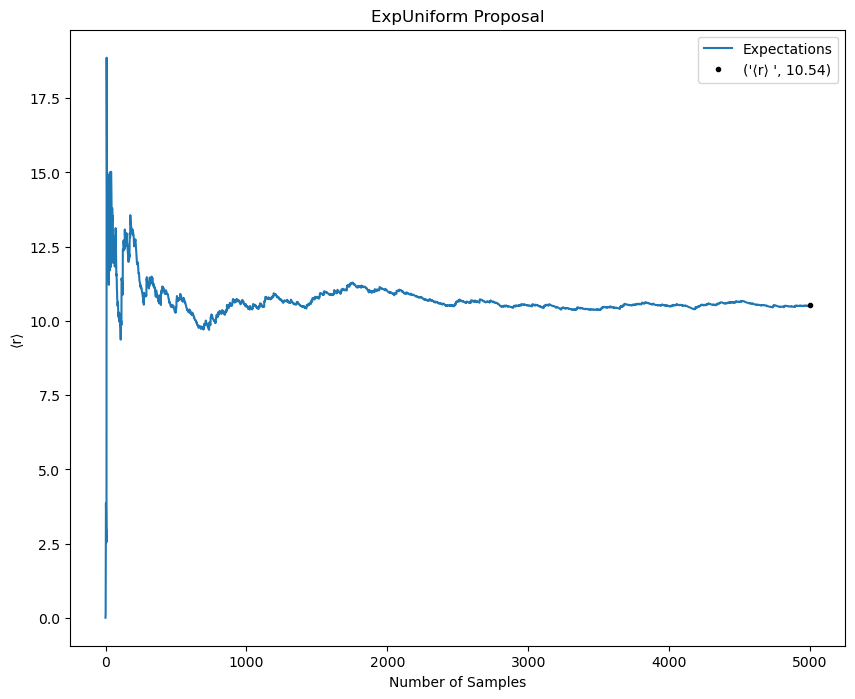

In [10]:

#### **** YOUR CODE HERE **** ####

#### Task 5b

#### Test the importance sampler

#### For each of the three different proposal distributions: 
#### - chart the convergence of the expectation
#### - print out the final expectation <r>

from scipy.stats import uniform

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1]) 
    PHI = RBF.evaluate(x_train)
    log_pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return log_pstar

def qrvs():
    ran_logalpha = np.random.uniform(-9,6)      # generates random value for log alpha with equal probability
    ran_logr = np.random.uniform(-2,2)          # generates random value for log r with equal probability
    x = [ran_logalpha, ran_logr]
    return x

def qstar(y):
    pdf_logalpha = 1.0/(6.0-(-9.0))
    pdf_logr = 1.0/(2.0-(-2.0))
    pdf_all = pdf_logalpha*pdf_logr             # joint pdf of log alpha and log r
    qstar = pdf_all
    log_qstar = np.log10(qstar)
    return log_qstar

def fun(y):
    r = 10**y[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, pstar, qstar, qrvs, fun)

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.', label=('⟨r⟩ ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('ExpUniform Proposal')
plt.show()

# ExpCentredGaussian

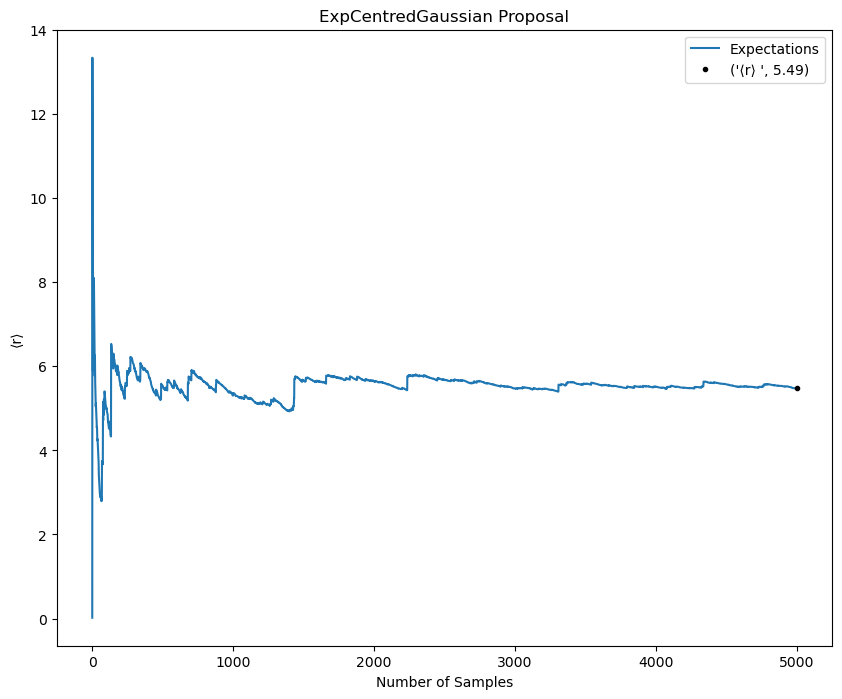

In [11]:
from scipy.stats import multivariate_normal

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return pstar

def qrvs():
    Mu = [-1.5, 0]                                                     # Gaussian centre
    Cov = [[2.5, 0],[0, 0.67]]                                         # 16/6 and 5/6
    model = multivariate_normal(Mu, Cov)                               # Gaussian Model
    y = model.rvs()
    return y

def qstar(y):
    Mu = [-1.5, 0]
    Cov = [[2.5, 0], [0, 0.67]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(y)
    qstar = np.log10(qstar)
    return qstar

def fun(y):
    r = 10**y[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, pstar, qstar, qrvs, fun)

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.', label=('⟨r⟩ ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('ExpCentredGaussian Proposal')
plt.show()


# ExpMaxGaussian

In [13]:
from scipy.stats import multivariate_normal

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return pstar
    
def qrvs():
    Mu = [-1.0, 0]                                                     
    Cov = [[1.4, 0],[0, 0.6]]                                         
    model = multivariate_normal(Mu, Cov)                               
    y = model.rvs()
    return y

def qstar(y):
    Mu = [1, 0]
    Cov = [[1.4, 0], [0, 0.6]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(y)
    qstar = np.log10(qstar)
    return qstar

def fun(y):
    r = 10**y[1]
    return r

num_samples = 5000
Expectations = importance(num_samples, pstar, qstar, qrvs, fun)

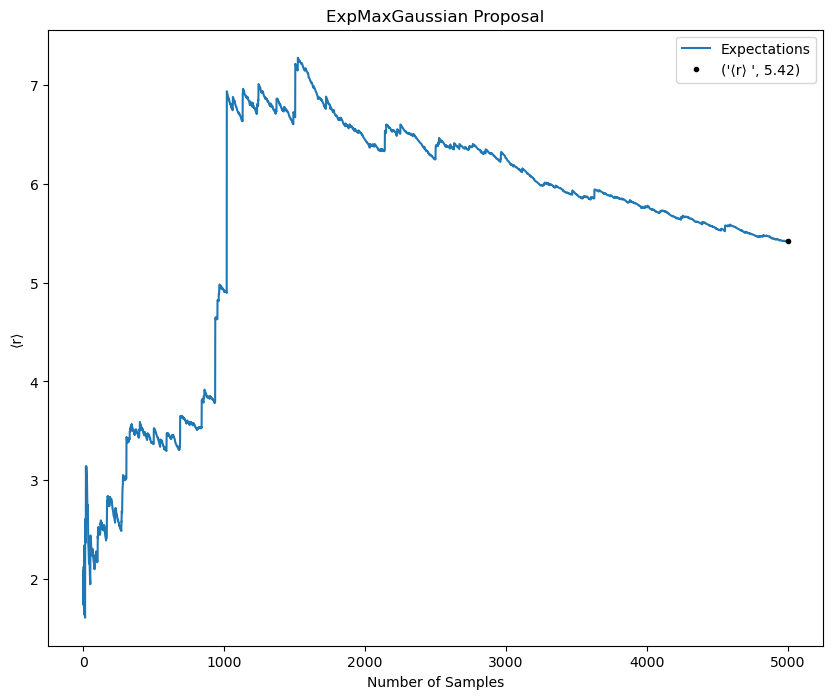

In [14]:
# plot for each of the three different proposal distributions
#### **** YOUR PLOTTING CODE HERE **** ####
#

plt.figure(figsize=(10,8))
plt.plot(Expectations, label='Expectations')
plt.plot(5000, Expectations[-1], 'k.', label=('⟨r⟩ ', round(Expectations[-1],2)))
plt.legend(loc='best')
plt.xlabel('Number of Samples')
plt.ylabel('⟨r⟩')
plt.title('ExpMaxGaussian Proposal')
plt.show()

In [25]:

#### **** You are free to add cells to make your code and visualization look better. **** ####
# Check whether your variables are defined as required  ..
try:
    out_ = importance(2, pstar, qstar, qrvs, fun)
    if not isinstance(out_,np.ndarray):
        print('The output of importance function should be an array of $2$ expectations')  
        
    if not out_.shape[0]==2:
        print('The accpeted num of outcome importance function should be 2 given the num_sample is 2')
        
    if not isinstance(ExpUniform,np.ndarray):
        print('ExpUniform should be an array of $K$ expectations')
        
    if not isinstance(ExpCentredGaussian,np.ndarray):
        print('ExpCentredGaussian should be an array of $K$ expectations')
        
    if not isinstance(ExpMaxGaussian,np.ndarray):
        print('ExpMaxGaussian should be an array of $K$ expectations')
        
except Exception as err:
    print('Error output:', err)

The output of importance function should be an array of $2$ expectations
Error output: 'list' object has no attribute 'shape'


### Task 5c (Bonus)
*Compare the convergence of the three samplers above by assessing the results over multiple runs (0.5 marks)*

For a given proposal distribution, add functionality (basically, an outer loop around your importance sampler) to compute the variance *at each sample step* of the returned `Expectations` vector over repeated runs of the sampler (don't fix the random number seed for each run!). Repeat for all three proposal distributions of Task 5b, and plot the variance(`VarUniform`,`VarCentredGaussian`,`VarMaxGaussian`) against sample number on the same graph.

If you have done this correctly, you should see all three variances tend to zero over time (2,000 samples roughly). Furthermore, the variance of the tuned Gaussian located at $\log\alpha_{\mathrm{MP}}$ and $\log r_{\mathrm{MP}}$ (Task 5b, proposal 3) should decrease a little more rapidly than the broad Gaussian centred at the midpoint of the visualisation (proposal 2), and both of these should be substantially better than the uniform (proposal 1).

100 repetitions should suffice to obtain convincing results, though as that takes a little while to run (two minutes maybe?), you will probably want to develop and test your solution on a smaller number to begin with.

To save time, it is not necessary to run for 5,000 samples in order to see the trend: 1,000 should suffice. 


In [26]:
#### **** YOUR CODE HERE **** ####

#### Task 5c

#### Importance sampler proposal convergence comparison

#### Output should be a graph showing the variance of the Expectations
#### against sample number, as computed over multiple repetitions, 
#### with all three proposals on the same axis.




# Check whether your variables are defined as the requirement  ..
try:
    if not isinstance(VarUniform,np.ndarray):
        print('VarUniform should be an array')
    if not isinstance(VarCentredGaussian,np.ndarray):
        print('VarCentredGaussian should be an array')
    if not isinstance(VarMaxGaussian,np.ndarray):
        print('VarMaxGaussian should be an array')
except Exception as err:
    print('Error output:', err)

Error output: name 'VarUniform' is not defined


# VarUniform

In [15]:

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1]) 
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return pstar

def qrvs():
    ran_logalpha = np.random.uniform(-9,6)      
    ran_logr = np.random.uniform(-2,2)          
    
    x = [ran_logalpha, ran_logr]
    return x

def qstar(y):
    pdf_logalpha = 1.0/(6.0-(-9.0))
    pdf_logr = 1.0/(2.0-(-2.0))
    pdf_all = pdf_logalpha*pdf_logr             
    qstar = pdf_all
    qstar = np.log10(qstar)
    return qstar

def fun(y):
    r = 10**y[1]
    return r

Exp_p1 = []
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, pstar, qstar, qrvs, fun)
    Exp_p1.append(temp_exp)
    
var_Exp_p1 = np.var(Exp_p1, axis=0)

print('Done!')

Done!


# VarCentredGaussian

In [16]:

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return pstar

def qrvs():
    Mu = [-1.5, 0]                                                     # Gaussian centre
    Cov = [[2.5, 0],[0, 0.67]]                                         # 16/6 and 5/6
    model = multivariate_normal(Mu, Cov)                               # Gaussian Model
    y = model.rvs()
    return y

def qstar(y):
    Mu = [-1.5, 0]
    Cov = [[2.5, 0], [0, 0.67]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(y)
    qstar = np.log10(qstar)
    return qstar

def fun(y):
    r = 10**y[1]
    return r

Exp_p2 = []
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, pstar, qstar, qrvs, fun)
    Exp_p2.append(temp_exp)
    
var_Exp_p2 = np.var(Exp_p2, axis=0)

print('Done!')

Done!


# VarMaxGaussian

In [17]:

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    return pstar
    
def qrvs():
    Mu = [-1.0, 0]                                                     
    Cov = [[1.4, 0],[0, 0.6]]                                         
    model = multivariate_normal(Mu, Cov)                               
    y = model.rvs()
    return y

def qstar(y):
    Mu = [1, 0]
    Cov = [[1.4, 0], [0, 0.6]]
    model = multivariate_normal(Mu, Cov)
    qstar = model.pdf(y)
    qstar = np.log10(qstar)
    return qstar

def fun(y):
    r = 10**y[1]
    return r

Exp_p3 = []
for i in range(100):
    num_samples = 1000
    temp_exp = importance(num_samples, pstar, qstar, qrvs, fun)
    Exp_p3.append(temp_exp)
    
var_Exp_p3 = np.var(Exp_p3, axis=0)

print('Done!')

Done!


# Variance Convergence Graphs

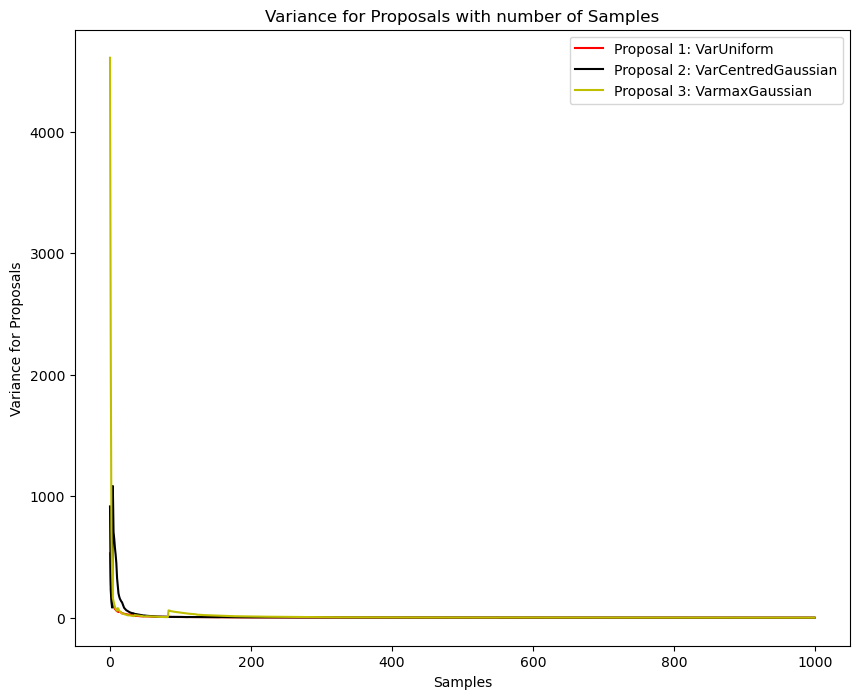

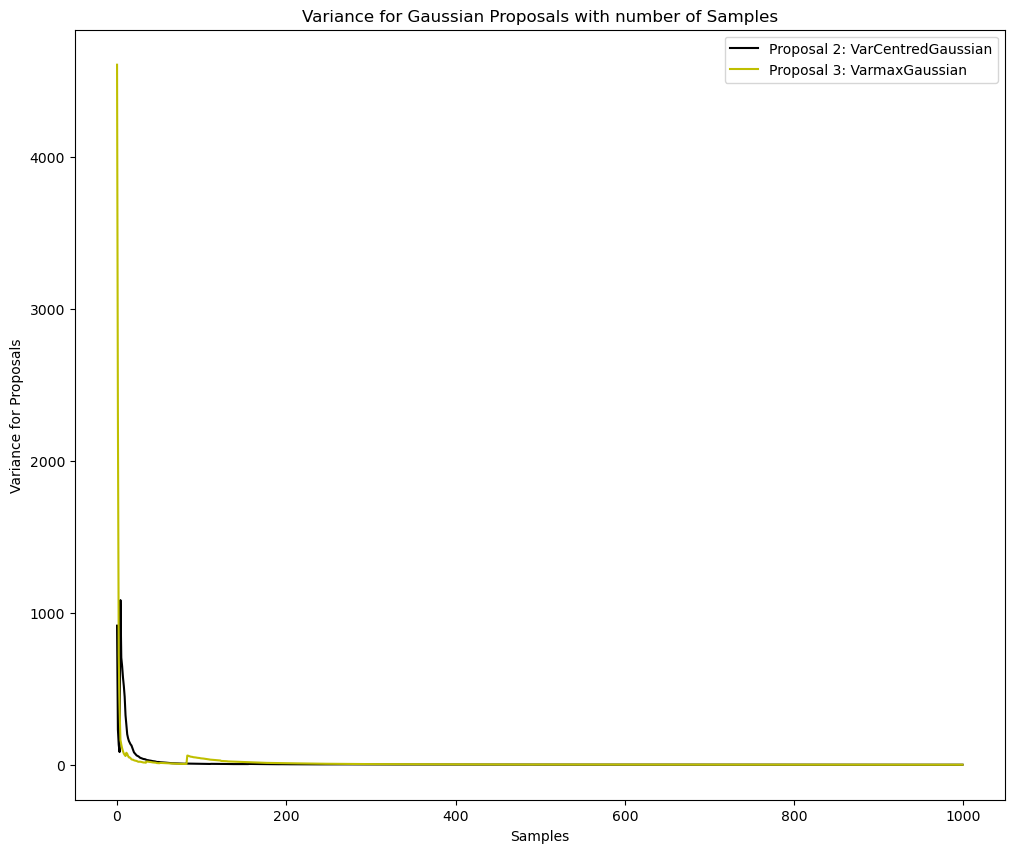

In [18]:
# plot 
#### **** YOUR PLOTTING CODE HERE **** ####
#

plt.figure(figsize=(10,8))
plt.plot(var_Exp_p1, 'r', label ='Proposal 1: VarUniform')
plt.plot(var_Exp_p2, 'k', label ='Proposal 2: VarCentredGaussian')
plt.plot(var_Exp_p3, 'y', label ='Proposal 3: VarmaxGaussian')
plt.legend(loc='best')
plt.xlabel('Samples')
plt.ylabel('Variance for Proposals')
plt.title('Variance for Proposals with number of Samples')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(var_Exp_p2, 'k', label='Proposal 2: VarCentredGaussian')
plt.plot(var_Exp_p3, 'y', label='Proposal 3: VarmaxGaussian')
plt.legend(loc='best')
plt.xlabel('Samples')
plt.ylabel('Variance for Proposals')
plt.title('Variance for Gaussian Proposals with number of Samples')
plt.show()



## Task 6: MCMC & The Metropolis Algorithm <a name="task6"></a>
(5 marks + 1 bonus marks)

This task focuses on implementing the Metropolis, MCMC sampling, algorithm, and again applying the sampler to find the expected value for basis function width $r$. This is also extended to estimation of the noise variance $\sigma^2$ and (bonus task) the weights $\mathbf{w}$.


### Task 6a
*Implement the Metropolis algorithm (2 marks)*

It is suggested that the algorithm be implemented as:

    samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x` and returns the corresponding $P^\ast(x)$, for example where `x = [log alpha, log r]`
- `qrvs` is a function object which takes a single argument `x` (current state), and generates a single proposal `xdash` sampled from $Q(x'|x)$
- `x0` is the starting state (experiment!), and should be included as the first element of the `samples`

Overall, the Metropolis implementation should need no more than 20 lines of code, and should return a matrix `samples` containing all the sample vectors (states), along with a matrix `rejected` containing all the proposed states that were *rejected*.

Similar to the importance case, the functions `pstar` and `qrvs` will be defined outside your main functon (in Task 6b next). 

Reminder: as can be seen in the algorithm specfication in the slides (but which is easy to forget!), when a proposal is rejected in the Metropolis algorithm, the current state must be *repeated* within the returned samples list.

In [19]:
#### **** YOUR CODE HERE **** ####

#### Task 6a

#### Metropolis algorithm implementation

def metropolis(num_samples, pstar, qrvs, x0):
    
    #### **** YOUR CODE HERE **** ####
    """This function implements the Metropolis
       algorithm and returns all the samples
       and rejected samples.
       
       Arguments
       ---------
       num_samples: number of samples
       pstar: the function returns the pstar value for a given x = [log_alpha, log r] value
       qvrs: The function generates a random x = [log_alpha, log r] value
       fun: converts log r to r
       
       Returns
       -------
       samples: all the samples taken into consideration
       rejected: all the samples rejected
       """
    
    samples = []
    rejected = []
    current_state = x0
    
    
    for n  in range (num_samples):
        xdash = qrvs(current_state)
        pstar_xdash = pstar(xdash)
        pstar_x = pstar(current_state)
        k = pstar_xdash/pstar_x
       
        
        if k>=1:
            current_state = xdash
            samples.append(xdash)
        else:
            if np.random.rand() < k:
                current_state = xdash
                samples.append(xdash)
            else:
                samples.append(current_state)
                rejected.append(xdash)
    
    return samples, rejected

### Task 6b
*Apply the Metropolis sampler to compute $\langle{}r\rangle$ again (4 marks)*

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | y)$ investigated above, using MCMC sampling as implemented by your Metropolis algorithm. Assume that $\sigma^2=0.2^2$ is known. The overall setup should be exactly the same as for the importance sampler, but with a different sampling algorithm. As you may realise, you can re-use the same `pstar` function, although you will need to change `qstar` and create a new `qrvs` to reflect the change in algorithm.

You should use a multivariate Gaussian for $Q$, but experiment with three different length scales (standard deviations):

1. one too narrow, which has a very high acceptance rate (anything over 80%), and which "random walks" 
2. one too broad, which has a low acceptance rate (say, around 5%)
2. one "just right", with acceptance rate between 20% and 30% (see below hint)

Some degree of "trial and error" is to be expected.

Having run your sampler, for each proposal you should:

- calculate and output the acceptance rate, which if you have coded it conventionally, should be `(num_samples-len(rejected)) / num_samples`
- plot the usual graph showing convergence: *i.e.* a graph of $\langle r\rangle$ with increasing sample number (exactly as done in Task 5b).
- print out the final value of $\langle r\rangle$ (the last point on the graph)
- re-create the earlier visualisation of $p(\alpha, r | y)$ and overlay the samples (optionally, you might also plot the rejected proposals too). It is suggested you also include the "burn in" samples here (but exclude them when calculating $\langle r\rangle$ - see note below)

You should be able to re-use quite a bit of earlier code to achieve the above. 

The sampler should return an array of $K$ expectations for three proposal ditributions as `exp_narrow`, `exp_broad`, `exp_right` and corresponding accepted rate `acc_narrow`, `acc_broad`,`acc_right` respectively.


Hints: 

- Remember that the proposal depends on the current state, unlike the importance sampler
- *e.g.* `qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[scale, scale])`
- `pstar` can be re-used from earlier (though it will need to be changed for Tasks 6c and 6d)
- To compute $\langle r\rangle$ at each sample step, you will need to average the samples up to that step. To do that for every step can be done in one line making use of `np.cumsum`
- Don't forget your samples will be of $\log r$ (along with $\log\alpha$)
- To accommodate "burn in", it is suggested to throw away the first 5% of samples, then average the rest (but don't sub-sample)
- It might be illuminating to initialise `x0` at random (within the $\log\alpha, \log r$ grid), or even deliberately badly
- A total of 10,000 samples should run in a few seconds, although to save time, you will probably want to use fewer when assessing the length scales (1,000 is fine there)
- There is some analysis to suggest that the "ideal" acceptance rate is around 23%
- A high rejection rate means inefficiency and many wasted samples, but too low a rate probably indicates "random walking". You should be able to clearly see this on your visualisation.


### FIX YOUR RANDOM SEEDS TO MAKE IT  REPRODUCIBLE. 

In [20]:
#### **** YOUR CODE HERE **** ####

#### Task 6b

#### Test the Metropolis algorithm implementation

#### For each of the three proposals, the output should be
#### - print out of the length-scale used for the proposal


#### - plot of convergence: <r> against sample number
#### - replot the previous visualisation, and overlay the samples (as a scatter plot on top)


####
#### - print out of the acceptance rate
#### - print out of the final value of <r>



# Q with high acceptance rate:Above 80%

Broad Scale with high performance rate
Acceptance rate:  82.5 %
Final value of <r>


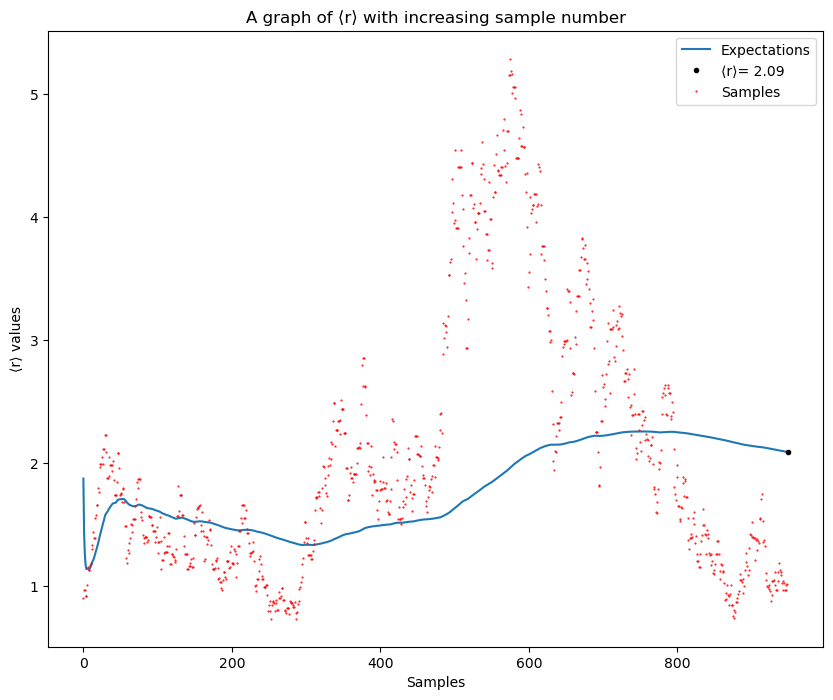

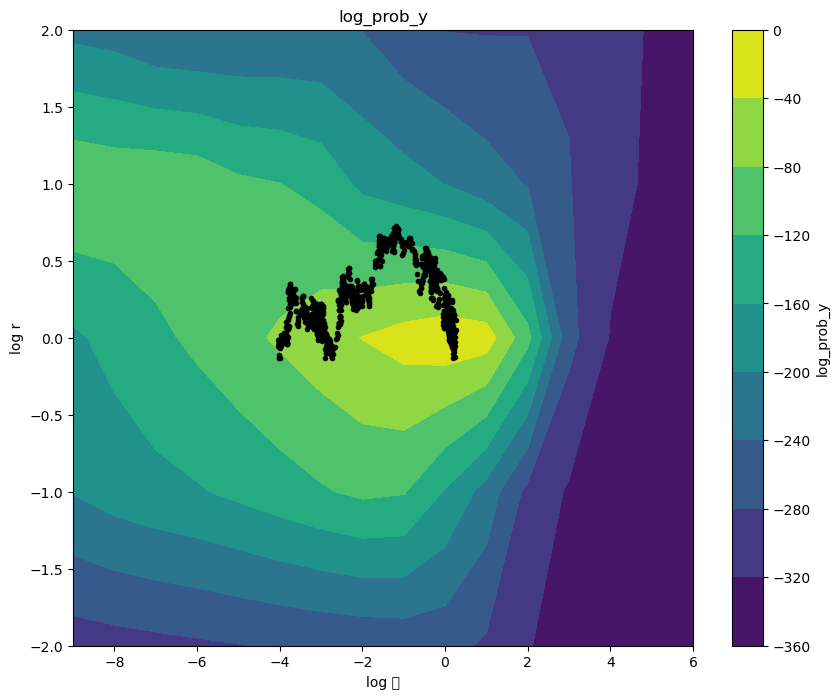

In [21]:
from scipy.stats import multivariate_normal

# define pstar, qvrs, x0 and num_samples
def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    pstar = 10**pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.0005, 0.001])
    
x0 = [-4, 0]

num_samples = 1000
samples_tag = [s for s in range(1,num_samples)]

samples, rejected = metropolis(num_samples, pstar, qrvs, x0)
    
    
# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*100/num_samples
print('Broad Scale with high performance rate')
print('Acceptance rate: ', acceptance_rate,'%')


log_r = [r[1] for r in samples]
r = np.power(10, log_r)
log_alpha = [r[0] for r in samples]


# Incorporate burn in 5%
r = r[51:]

#Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)
    

print ("Final value of <r>")
    
# Convergence graph for r
plt.figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k. ',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('A graph of ⟨r⟩ with increasing sample number')
plt.show()

#Length_scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(log_prob_y_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log 𝛼')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('log_prob_y')
plt.title('log_prob_y')
plt.show()

# Q with low acceptance rate 5%

Narrow Scale  with low performance rate
Acceptance rate:  4.5 %


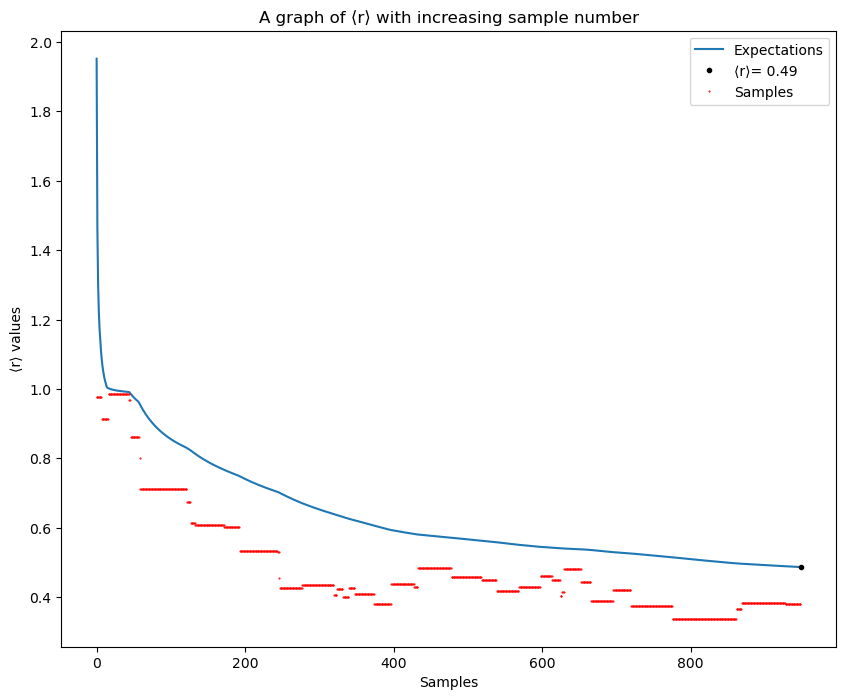

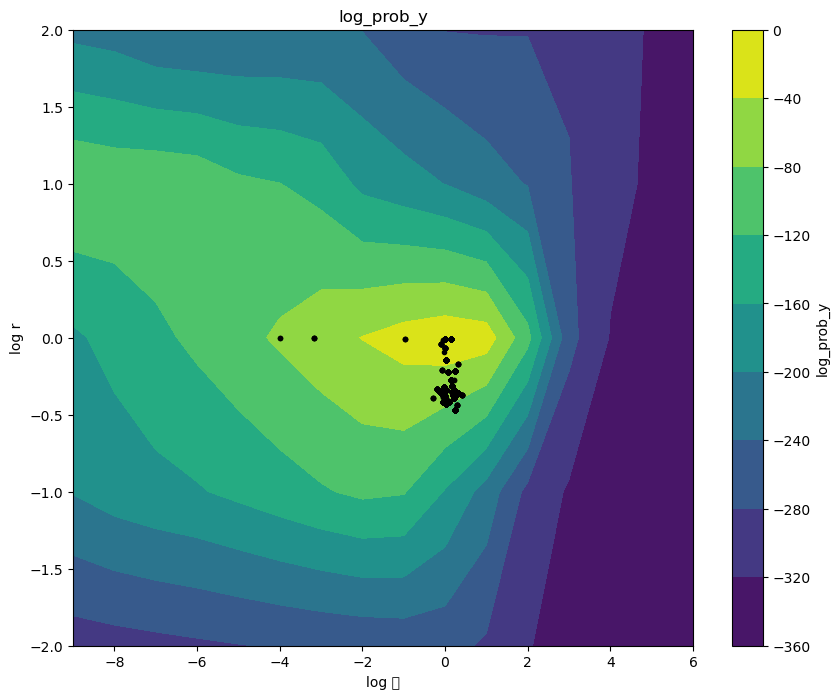

In [23]:
from scipy.stats import multivariate_normal

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    pstar = 10**pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[10, 0.001])
    
x0 = [-4, 0]

num_samples = 1000
samples, rejected = metropolis(num_samples, pstar, qrvs, x0)
    
    
# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*100/num_samples
print('Narrow Scale  with low performance rate')
print('Acceptance rate: ', acceptance_rate,'%')


log_r = [r[1] for r in samples]
r = np.power(10, log_r)

log_alpha = [r[0] for r in samples]

# Incorporate burn in 5%
r = r[51:]

#Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)
    
    
    
# Convergence graph for r
plt. figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k. ',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('A graph of ⟨r⟩ with increasing sample number')
plt.show()



#Length_scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(log_prob_y_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log 𝛼')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('log_prob_y')
plt.title('log_prob_y')
plt.show()

# Q with good acceptance rate: 25%

Appropriate Scale with good acceptance rate
Acceptance rate:  26.35 %


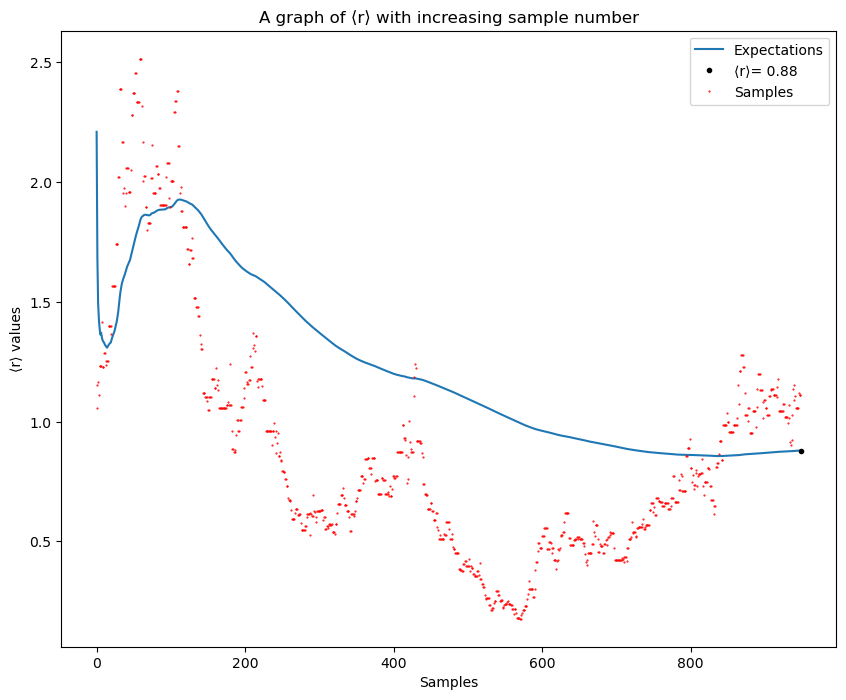

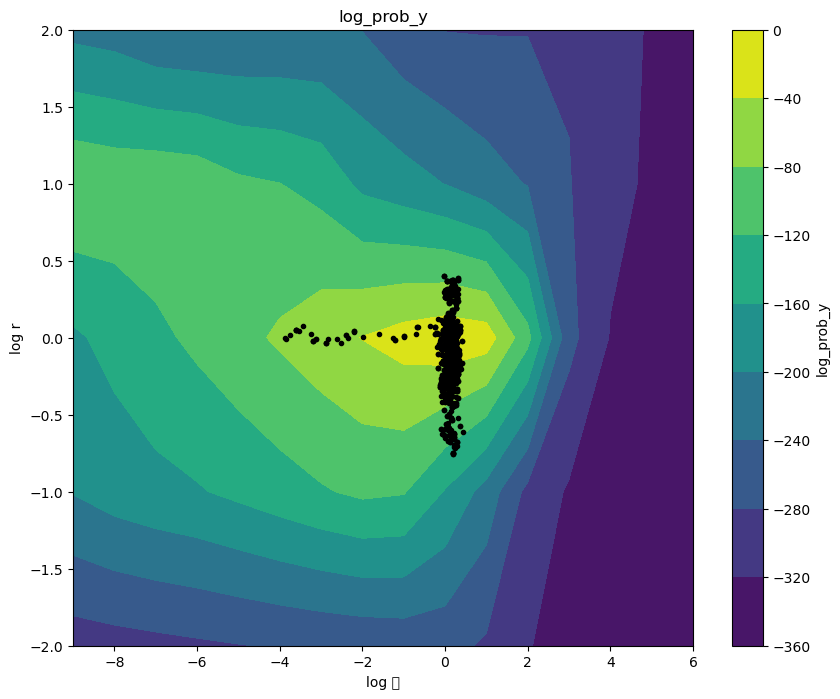

In [24]:
from scipy.stats import multivariate_normal

def pstar(y):
    RBF = CWP2.RBFGenerator(centres, 10**y[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**y[0], s2)
    pstar = 10**pstar
    return pstar

qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.04, 0.001])
    
x0 = [-4, 0]

num_samples = 1000
samples, rejected = metropolis(num_samples, pstar, qrvs, x0)
    
    
# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected))*50/num_samples
print('Appropriate Scale with good acceptance rate')
print('Acceptance rate: ', acceptance_rate,'%')


log_r = [r[1] for r in samples]
r = np.power(10, log_r)

log_alpha = [r[0] for r in samples]

# Incorporate burn in 5%
r = r[51:]

#Calculate expectation values for r
Exp_r_sums = np.cumsum(r, axis=0)

Exp_r = []
for e in range(1, len(Exp_r_sums)):
    exp_r = Exp_r_sums[e]/(e*1.0)
    Exp_r.append(exp_r)
    
# Convergence graph for r
plt. figure(figsize=(10,8))
plt.plot(Exp_r, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_r[-1], 'k. ',label=('⟨r⟩= %.2f' %Exp_r[-1]))
plt.plot(r, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨r⟩ values')
plt.xlabel('Samples')
plt.title('A graph of ⟨r⟩ with increasing sample number')
plt.show()

#Length_scale proposal with sample overlay
plt.figure(figsize=(10,8))
plt.contourf(x_alpha, x_r, np.transpose(log_prob_y_mat))
plt.plot(log_alpha, log_r, 'k.')
plt.xlabel('log 𝛼')
plt.ylabel('log r')
plt.colorbar().ax.set_ylabel('log_prob_y')
plt.title('log_prob_y')
plt.show()

In [ ]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

In [ ]:
#### **** You are free to add cells to make your code and visualization look better. **** ####
# Check whether your variables are defined as the requirement  ..
try:
    if not isinstance(exp_narrow,np.ndarray):
        print('exp_narrow should be an array of $K$ expectations')
    if not isinstance(exp_broad,np.ndarray):
        print('exp_broad should be an array of $K$ expectations')
    if not isinstance(exp_right,np.ndarray):
        print('exp_right should be an array of $K$ expectations')
    acc_narrow
    acc_broad
    acc_right
except Exception as err:
    print('Error output:', err)

### Task 6c: Bonus
*Extend your Metropolis sampler to estimate the noise variance $\sigma^2$ (0.5 mark)*

Extend the above example to include the noise variance $\sigma^2$. Assume a uniform log prior as usual, and sample in $\log \sigma^2$ space. Depending on how you have coded up your sample and proposal functions, this could be a very straightforward task. (You will need to adapt the earlier `pstar` function at this point.)

For the output of this task, simply show a single graph, using your earlier code, of the convergence of $\langle\sigma^2\rangle$ (over, say, 10,000) samples and return an array of $K$ expectations of s2 `s2_expected ` and the square-root of the final expecation value (which should be not far from the true value of 0.2).

In [25]:
#### **** YOUR CODE HERE **** ####

#### Task 6c

#### Extend the Metropolis sampler to estimate the noise std dev

#### Output should be
#### - print out of the length-scale used for the proposal
#### - print out of the acceptance rate
#### - plot of convergence: <s2> against sample number
#### - print out of the final estimate of noise standard deviation


In [26]:
def pstar_s2(x):
    
    """Arguments
       ---------
       x[0]: log alpha
       x[1]: log r
       x[2]: log s2
       """
    RBF = CWP2.RBFGenerator(centres, 10**x[1])
    PHI = RBF.evaluate(x_train)
    pstar = CWP2.compute_log_marginal(PHI_train, y_train, 10**x[0], 10**x[2])
    pstar = 10**pstar
    return pstar

Appropriate Scale with good acceptance rate
Acceptance rate:  2.6 %
Final estimate of noise standard deviation s2: 0.04


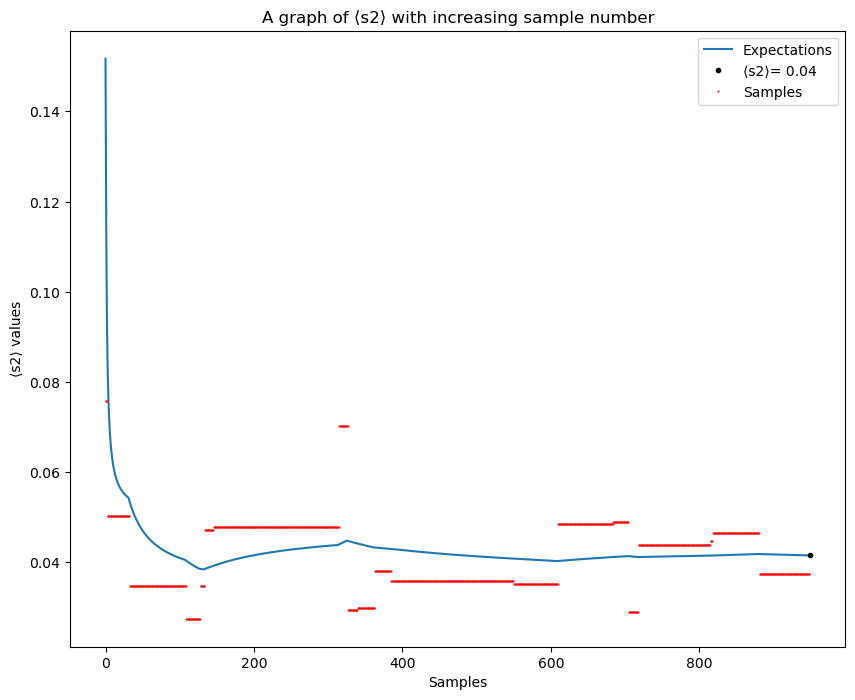

In [27]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

qrvs_s2 = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[0.4, 0.001, 1.5])
    
x0s2 = [-4, 0, 0]

num_samples = 1000
samples_s2, rejected_s2 = metropolis(num_samples, pstar_s2, qrvs_s2, x0s2)
    
    
# Calculate acceptance rate
acceptance_rate = (num_samples - len(rejected_s2))*100/num_samples
print('Appropriate Scale with good acceptance rate')
print('Acceptance rate: ', acceptance_rate,'%')


log_s2 = [s2[2] for s2 in samples_s2]
s2 = np.power(10, log_s2)

# Incorporate burn in 5%
s2 = s2[51:]

#Calculate expectation values for s2
Exp_s2_sums = np.cumsum(s2, axis=0)

Exp_s2 = []
for e in range(1, len(Exp_s2_sums)):
    exp_s2 = Exp_s2_sums[e]/(e*1.0)
    Exp_s2.append(exp_s2)
    
print("Final estimate of noise standard deviation s2: %.2f" %Exp_s2[-1])    
   
# Convergence graph for <s2>
plt. figure(figsize=(10,8))
plt.plot(Exp_s2, label='Expectations') # Plotting values after Burn in
plt.plot(949, Exp_s2[-1], 'k. ',label=('⟨s2⟩= %.2f' %Exp_s2[-1]))
plt.plot(s2, 'ro', markersize=0.5, label='Samples')
plt.legend(loc='best')
plt.ylabel('⟨s2⟩ values')
plt.xlabel('Samples')
plt.title('A graph of ⟨s2⟩ with increasing sample number')
plt.show()

In [28]:
# Check whether your variables are defined as the requirement  ..
try:
    if not isinstance(s2_expected,np.ndarray):
        print('s2_expected should be an array of $K$ expectations')
except Exception as err:
    print('Error output:', err)

Error output: name 's2_expected' is not defined


### Task 6d: Bonus
*Be "strictly Bayesian" and sample all the model unknowns to derive the mean predictor (0.5 mark)*

Extend your Metropolis algorithm to sample over *all* the unknowns in the model: that is, not just $\alpha$, $\sigma$, $r$ as in Task 6c, but also the weights $\mathbf{w}$. This is slightly artificial, in that we don't really need to sample the weights in this model (the posterior over $\mathbf{w}$ is analytically computable), but it demonstates the principle. In a neural network model (which will be nonlinear in $\mathbf{w}$), we *will* need to sample.

The objective of this task is to plot the "average" predictor at the points `x_test` (you may re-use `plot_regression` for the actual graphing). The quantity to be found is:

$$
\langle \mathbf{y} \rangle = \int (\mathbf{\Phi_\ast} \mathbf{w}) . p(\mathbf{w}, \alpha, r, \sigma^2 | y)\, d\mathbf{w}\, d\alpha\, dr\, d\sigma^2,
$$
where $\mathbf{\Phi_\ast}$ is the basis matrix evaluated at `x_test`.

You will need to set up your Metropolis algorithm to sample from $p(\mathbf{w}, \alpha, r, \sigma^2 | y)$. This is of course given by Bayes' rule:

$$
p(\mathbf{w}, \alpha, r, \sigma^2 | y) = \frac{p(y|\mathbf{w}, r, \sigma^2)\,p(\mathbf{w}| \alpha)\,p(\alpha)\,p(r)\,p(\sigma^2)}{p(y)}.
$$
From this, we can identify
$$
P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(y|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)\, p(\alpha)\,p(r)\, p(\sigma^2)
$$
where

- $p(y|\mathbf{w}, \sigma^2)$ is the Gaussian likelihood probability model 
- $p(\mathbf{w}| \alpha)$ is the Gaussian weight prior 
- $p(\alpha)$, $p(r)$ and $p(\sigma^2)$ are hyperpriors, which if defined as uniform over $\log\alpha$, $\log r$ and $\log\sigma$ respectively, may be considered constant

The state space here will be 19-dimensional, due to the 16 weights combined with $\alpha$, $r$ and $\sigma^2$. A relatively narrow Gaussian proposal distribution $Q(\theta^\prime| \theta)$ should work OK, though you may wish to experiment with the length scales. Ideally, you would use different length scales for the three parameter types, though this is an unnecessary complication in the context of this exercise (no marks deducted for not doing it).

So your approach might be:

- Define $P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(y|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)$ (all other terms in the numerator being constant and therefore unnecessary),define a function `new_log_pstar(x)` to calculate posterior where x is the 19-dimensional state.
- Use this to generate a set of samples of $\mathbf{w}, \alpha, r, \sigma^2$ using your Metropolis algorithm (use 10,000 samples for your final results)
- Suggest you aim for an acceptance rate of around 25% (not precisely critical)
- For each sample, compute the appropriate basis matrix and subsequent predictor
    - `RBF = CWP2.RBFGenerator(centres, r)` using sampled $r$
    - `PHI_test = RBF.evaluate(x_test)`
    - `y_pred = PHI_test @ w` using sampled $\mathbf{w}$ and giving a 250-long vector of predictions at the test points
- Average all the `y_pred` vectors to give the overall mean predictor as  `y_pred_mean`
- At the same time, as a sanity check, you might want to compute $\langle \sigma \rangle$ from the same set of samples, which should be in the region of 0.2 (optional, but easy to do)

*If you have done this right, you should find that your predictor is a very good fit to the generating function, taking the limitations of the training data into account.*





In [29]:
#### **** YOUR CODE HERE **** ####

#### Task 6d

#### Extend the Metropolis sampler to estimate the noise std dev

#### Output should be
#### - a single plot of the mean predictor
#### - [optional] estimate of sigma
####



# Check whether your variables are defined as the requirement  ..
try:
    if not isinstance(y_pred_mean,np.ndarray):
        print('y_pred_mean should be an array of $K$ expectations')
except Exception as err:
    print('Error output:', err)

Error output: name 'y_pred_mean' is not defined


In [30]:
best_r = 1.17
RBF = CWP2.RBFGenerator(centres, best_r)
new_PHI_train = RBF.evaluate(x_train)

In [31]:
from scipy.stats import multivariate_normal

qrvs = lambda X, COV: multivariate_normal.rvs(size=1, mean=X, cov=COV)

def pstar(w, alph, s2, y, PHI):
    """Reimplementing pstar to handle posterior weights."""
    N,M = PHI.shape
    # p1 is P(y|w,σ2)
    p1 = np.prod(multivariate_normal.pdf(y-np.dot(PHI,w).reshape(N,1),mean=None,cov=s2))
    # p2 is P(w|α)
    p2 = np.prod(multivariate_normal.pdf(w,mean=None,cov=alph**(-1)))
    # prob is P∗(w,α,σ2)
    prob = p1 * p2     
                 
    return prob

In [32]:
from scipy.stats import multivariate_normal

qrvs = lambda X, COV: multivariate_normal.rvs(size=1, mean=X, cov=COV)

def new_log_pstar(w, alph, s2, y, PHI):
    """Reimplementing pstar to handle posterior weights."""
    N,M = PHI.shape
    # p1 is p(𝑦|𝐰,𝜎2)
    p1 = np.prod(multivariate_normal.pdf(y-np.dot(PHI,w).reshape(N,1),mean=None,cov=s2))
    # p2 is 𝑝(𝐰|𝛼)
    p2 = np.prod(multivariate_normal.pdf(w,mean=None,cov=alph**(-1)))
    # prob is P*(w,𝛼,𝜎2)
    prob = p1 * p2
    return prob

def Metropolis(PHI, y, K = 10000, scale = 0.001, burn_rate = 0.1):
    """Reimplementing Metropolis algorithm to handle posterior weights."""
    if y.ndim== 1:
        y = y.reshape(-1, 1)
    N,M = PHI.shape
    XO = np.zeros(M+2)
    COV = np.eye(M+2,M+2)*scale
    current_state = XO
    accept = []
    reject = []
    for i in range(K):
        next_state = qrvs(current_state, COV)
        p_new = pstar(next_state[:-2], np.exp(next_state[-2]), np.exp(next_state[-1]), y, PHI)
        p_old = pstar(current_state[:-2], np.exp(current_state[-2]), np.exp(current_state[-1]), y, PHI)
        
        p = p_new/p_old
        
        if p >= 1:
            accept.append(next_state)
            current_state = next_state
        else:
            if np.random.rand() < p:
                accept.append(next_state)
                current_state = next_state
            else:
                reject.append(next_state)
                accept.append(current_state)
            
    reject_rate = len(reject)/K                    
    print('Rejection rate is', reject_rate*100, '%')
    
    # burn in
    start_point = round(len(accept) * burn_rate)
    weights = np.array(accept)[start_point:].mean(axis = 0)
    
    return weights[:-2]    

In [33]:
def predict(target_PHI, weights):
    
    prediction = np.dot(target_PHI, weights)
    
    return prediction

weights3 = Metropolis(new_PHI_train, y_train, K = 10000, scale = 0.001, burn_rate = 0.05)
y_train_pred3 = predict(PHI_train, weights3)
y_test_pred3 = predict(PHI_test, weights3)

Rejection rate is 41.5 %


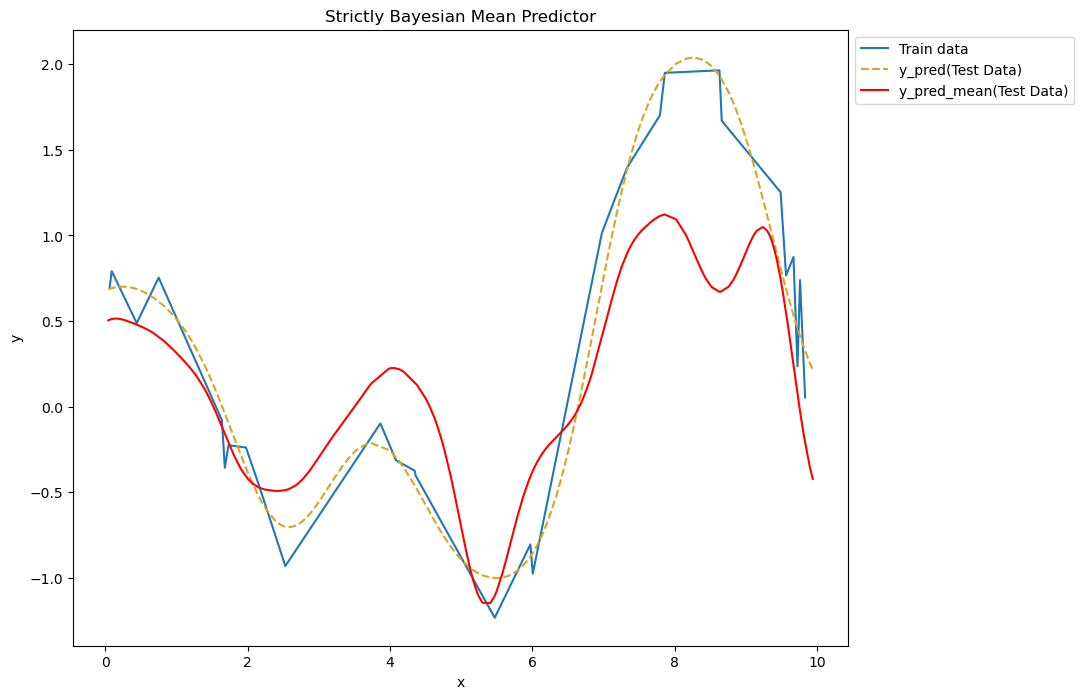

In [34]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

plt.figure(figsize=(10,8))
plt.plot(x_train, y_train, '-', label = 'Train data')
plt.plot(x_test, y_test, '--', color='goldenrod', label = 'y_pred(Test Data)')
plt.plot(x_test, y_test_pred3, c= 'r', label = 'y_pred_mean(Test Data)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Strictly Bayesian Mean Predictor')
plt.show()